# ***PA - Part III: Training a Robust Model - Optional/Bonus*** (10pt)

**Keywords**: Adversarial Robustness Training

**About the dataset**: \
The [MNIST](https://en.wikipedia.org/wiki/MNIST_database) database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems.\
The MNIST database contains 70,000 labeled images. Each datapoint is a $28\times 28$ pixels grayscale image.

**Agenda**:
* The PA is split into three parts, the first part dealing with miniature models which we will build from scratch, the second part dealing with modern architectures and the bonus third part dealing with training vision models robust to adversarial attacks.
* In this part, you will train a 2-hidden layer neural network which is robust to adversarial attacks.
* You will train models on adversarial examples generated using FGSM and PGD.

**Note:**
* Hardware acceleration (GPU) is recommended but not required for this part.
* A note on working with GPU:
  * Take care that whenever declaring new tensors, set `device=device` in parameters.
  * You can also move a declared torch tensor/model to device using `.to(device)`.
  * To move a torch model/tensor to cpu, use `.to('cpu')`
  * Keep in mind that all the tensors/model involved in a computation have to be on the same device (CPU/GPU).
* Run all the cells in order.
* Only **add your code** to cells marked with "TODO:" or with "..."
* You should not have to change variable names where provided, but you are free to if required for your implementation.

### ***Setup: Imports and Utils***

In [1]:
# install this library
!pip install gdown

In [2]:
# imports
import torch
import torch.nn as nn
import numpy as np
import requests
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import gdown
from zipfile import ZipFile

# set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# loading the dataset full MNIST dataset
mnist_train = datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("./data", train=False, download=True, transform=transforms.ToTensor())

mnist_train.data = mnist_train.data.to(device)
mnist_test.data = mnist_test.data.to(device)

mnist_train.targets = mnist_train.targets.to(device)
mnist_test.targets = mnist_test.targets.to(device)

# reshape and min-max scale
X_train =  (mnist_train.data.reshape((mnist_train.data.shape[0], -1))/255).to(device)
y_train = mnist_train.targets
X_test = (mnist_test.data.reshape((mnist_test.data.shape[0], -1))/255).to(device)
y_test = mnist_test.targets

# first few examples
example_data = mnist_test.data[:18]/255
example_data_flattened  = example_data.view((example_data.shape[0], -1)).to(device) # needed for training
example_labels = mnist_test.targets[:18].to(device)



---



---




### **Adversarial training:**
* To train robust models, the most intuitive strategy is to train on adversarial examples.
* The adversarial (robust) loss function is defined as:
$\underset{\theta}{\min} \frac{1}{|S|}\sum_{x,y\in S} \underset{∥δ∥≤ϵ}{\max}\,ℓ(h_θ(x+δ),y)$, \
where $\theta$ are the learnable parameters, $S$ is the set of training examples with $x$ representing the input example and $y$ the ground truth label, $h_\theta$ is the score function (neural network model), $\delta$ is the attack perturbation, and $\epsilon$ is the attack budget.

* This is also known as the min-max loss function. The gradient descent step now becomes:\
$\theta:=\theta-\frac{\alpha}{|B|}\sum_{x,y\in B} ∇_θ \underset{∥δ∥≤ϵ}{\max}\,ℓ(h_θ(x+δ),y)$,\
where $B$ is the mini-batch and $\alpha$ is the learning rate.

* Now the question becomes how to solve the inner term: $∇_θ \underset{∥δ∥≤ϵ}{\max}\,ℓ(h_θ(x+δ),y)$ of the gradient descent step.
* For this, we can use **Danskin’s Theorem**, which states that to compute the (sub)gradient of a function containing a max term, we need to simply
  1. find the maximum and,
  2. compute the normal gradient evaluated at this point.
* This holds only when you have the exact maximum.  Note that it is not possible to solve the inner maximization problem exactly (NP-hard). However, the better job we do of solving the inner maximization problem, the closer it seems that Danskin’s theorem starts to hold. That is why we can re-use methods such as FGSM/PGD to find approximate worst case examples.
* In other words, we can perform the attack to find $δ^{*} = \underset{∥δ∥≤ϵ}{\arg\max}ℓ(h_θ(x+δ),y)$, and then compute this term at the perturbed image: $∇_θℓ(h_θ(x+δ^{*}),y)$.

In summary, we will create an adversarial example for each datapoint in the mini-batch and use the loss corresponding to these adversarial examples to compute the gradient.  

We explore two attacks to get the perturbration - Fast Gradient Sign Method (FGSM) and Projected Gradient Descent (PGD)

* In the Fast Gradient Sign Method (FGSM), the perturbation $\delta$ on an input example (e.g. input image) $X$ is given by $\epsilon\cdot \text{sign}(g)$.
  * Here, $g$ is the gradient of the loss function $g:=\nabla_\delta \ell(h_\theta (x+\delta),y)$.
  * $\ell$ is the loss function, more precisely `nn.CrossEntropyLoss`. In the first timestep, this value of $\delta$ is $0$.

* For the Projected Gradient Descent (PGD) attack, you will create an adversarial example by iteratively performing **steepest descent** with a fixed step size $\alpha$.
  * The update rule is: $\delta:=P(\delta+\alpha\,\text{sign}(\nabla_\delta \ell(h_\theta(x+\delta),y)))$.
  * Here $\delta$ is the perturbation, $\theta$ are the frozen DNN parameters, $x$ and $y$ is the training example and its ground truth label respectively.
  * $h_\theta$ is the score function and $\ell$ denotes the loss function.
  * $P$ denotes the projection onto a norm ball ($l_\infty, l_1, l_2$, etc.) of interest. For $l_\infty$ ball, this just means clamping the value of $\delta$ between $-\epsilon$ and $\epsilon$.





---



### *(a) Setup* (4pt)

* In this part you will create a few adversarial examples using FGSM and PGD attacks. Use an attack budget $\epsilon=0.05$.


#### #1. Define the `fgsm` function

* Define a function `fgsm` which takes as input the neural network model (`model`), test examples (`X`), target labels (`y`), and the attack budget (`epsilon`).
* Return the value of the perturbation ($\delta$) after one gradient descent step.

In [3]:
#######
#TODO:
def fgsm(model, x, y, epsilon):
    x.requires_grad = True
    output = model(x)
    model.zero_grad()
    loss = nn.CrossEntropyLoss()(output, y) # Most Precisely: Cross Entropy loss
    loss.backward()
    delta = epsilon * x.grad.sign() # 𝛿 = 𝜖⋅sign(𝑔)
    x_adv = x + delta
    x_adv = torch.clamp(x_adv, 0, 1) # Ensure valid pixel range after adding perturbation: in MNIST: float between [0,1]
    delta = x_adv - x
    return delta
#######


#### #2. Define the `pgd` function

* Instead of using FGSM, now use Projected Gradient Descent (PGD) with projection on $l_\infty$ ball for the attack.
* Define a function `pgd` that takes as input the neural network model (`model`), training examples (`X`), target labels (`y`), step size (`alpha`), attack budget (`epsilon`), and number of iterations (`num_iter`).
* Return the perturbation ($\delta$) after `num_iter` gradient descent steps.

In [4]:
#TODO:

def pgd(model, x, y, alpha, epsilon, num_iter):
    # random sampling uniformly between 0 and 1
    delta = torch.rand_like(x) # Every element in tensor delta ~ U(0, 1)
    # bring delta in -eps to eps range
    # how? --> [0, 1] --> [0, 2*eps] --> [-eps, eps]
    delta = delta * 2 * epsilon - epsilon
    delta.requires_grad = True

    for t in (range(num_iter)):
        output = model(torch.clamp(x + delta, 0, 1)) # Ensure valid pixel range after adding perturbation: in MNIST: float between [0,1]
        loss = nn.CrossEntropyLoss()(output, y)
        model.zero_grad()
        loss.backward()

        delta.data = delta.data + alpha * torch.sign(delta.grad.data) # Update delta: 𝛿+𝛼sign(∇𝛿ℓ(ℎ𝜃(𝑥+𝛿),𝑦))
        delta.data = torch.clamp(delta, -epsilon, epsilon) # Projection to [-ε, ε] l∞ ball: 𝛿:=𝑃(𝛿+𝛼sign(∇𝛿ℓ(ℎ𝜃(𝑥+𝛿),𝑦)))
        delta.data = torch.clamp(x + delta, 0, 1) # Ensure valid pixel range after adding perturbation: in MNIST: float between [0,1]
        delta.grad.zero_()

    return delta

#### #3. Define a 2 hidden-layer NN in PyTorch

* Create a 2-hidden-layer neural network model in PyTorch.
* The input should be the size of the flattened MNIST image, and output layer should be of size 10, which is the number of target labels.
* Each of the two hidden layers should be of size 1024 with ReLU activations between each subsequent layer except the last layer.

You can refer to the structure of `NN_Model` from Part 1 (d) #5

In [5]:
#######
from torch.nn.functional import relu
#TODO:
class NN_Model(nn.Module):
    def __init__(self):
      super(NN_Model, self).__init__()
      # Initalize various layers of model as instructed below
      # 1. initialize three linear layers: num_features -> 32, 32 -> 16, 16 -> num_targets
      self.fc1 = torch.nn.Linear(784, 32)
      self.fc2 = torch.nn.Linear(32, 16)
      self.out = torch.nn.Linear(16, 10)

      # 2. initialize RELU
      self.relu = torch.nn.ReLU()

    def forward(self, X):
      # 3. define the feedforward algorithm of the model and return the final output
      # Apply non-linear ReLU activation between subsequent layers
      x1 = self.relu(self.fc1(X)) # Hidden Layer 1 -> Hidden Layer 2: ReLU
      x2 = self.relu(self.fc2(x1)) # Hidden Layer 2 -> Output: ReLU
      output = self.out(x2) # Output Layer
      return output

#######

#### #4. Adversarial Training Framework

* Define a function `train_torch_model_adversarial`
  * which takes as input: a PyTorch model (`model`), batch size (`batch_size`), loss function (`criterion`), maximum number of epochs (`max_epochs`), training data (`X_train, y_train`), learning rate (`lr`), tolerance for stopping (`tolerance`), adversarial strategy (`adversarial_strategy`: `None/'fgsm'/'pgd'`), and attack budget(`epsilon`).
  * Note: use an SGD optimizer with the given learning rate (`lr`) to update all the model parameters.
* If `adversarial_strategy` is `None`, don't train on adversarial examples.
* This function will return a tuple of `(model, losses)`, where `model` is the trained model, and `losses` are a list of tuple of loss logged every epoch.
* The only difference from the function `train_torch_model` that you wrote in Part 1 (c) #2 is that you find the adversarial noise using an attack (based on `adversarial strategy`) and add it to the input before training with it.

In [6]:
#######
#TODO:
def train_torch_model_adversarial(model, batch_size, criterion, max_epochs, \
                                  X_train, y_train, lr, tolerance, \
                                  adversarial_strategy, epsilon):
    losses = []
    num_batches = X_train.shape[0] // batch_size
    prev_loss = float('inf')
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    model.to(device)

    for epoch in tqdm(range(max_epochs)):
      for i in range(num_batches):
        start = i * batch_size
        end = start + batch_size
        X_train_batch = X_train[start:end]
        y_train_batch = y_train[start:end]

        # Generate Adversarial noise using an attack (based on fgsm/pgd)
        delta = 0

        if adversarial_strategy is not None:
          if adversarial_strategy == 'fgsm':
            delta = fgsm(model, X_train_batch, y_train_batch, epsilon)
          elif adversarial_strategy == 'pgd':
            alpha = 0.01
            num_iter = 40
            delta = pgd(model, X_train_batch, y_train_batch, alpha, epsilon, num_iter)

        X_train_batch = X_train_batch + delta
        X_train_batch = torch.clamp(X_train_batch, 0, 1)

        # Reset gradients
        optimizer.zero_grad()

        # Output
        output = model(X_train_batch)

        # Calculate loss
        loss = criterion(output, y_train_batch)

        # Backpropagate loss
        loss.backward()

        # Perform a single gradient update step
        optimizer.step()

    #######

      # log loss every epoch and print every 5 epochs (including 20th epoch)
      # Should we append the average loss of the epoch? or just in the last batch?
      losses.append((epoch, loss.item()))
      if epoch % 5 == 0 or epoch == max_epochs - 1:
          print('Epoch: {}, Loss: {}'.format(epoch, loss.item()))

      # break if decrease in loss is less than threshold
      if abs(prev_loss - loss.item()) < tolerance:
        print(f"Break! Early stopping at epoch {epoch}")
        break
      prev_loss = loss.item()

    return model, losses

#######



---



### *(b) Training and evaluation with different strategies (3 points)*

####  #1. Standard, FGSM-based, and PGD-based training

* Train three models:
  * without adversarial training,
  * with adversarial training using `fgsm`
  * with adversarial training using `pgd`.
* Hyperparameters
  * Use attack budget `epsilon` of 0.05.
  * Use a batch-size 512
  * Train for 20 epochs with learning rate $10^{-2}$, and early stopping tolerance of $10^{-6}$.
  * For `pgd`, use a step-size `alpha=0.01` and number of iterations `num_iter=40` when training.

  Note: PGD implementation will be slow (1hr+) when using a non-GPU runtime.

In [7]:
#######
#TODO: To put three trained model into a standard training process
trained_models = {}
batch_size = 512
tolerance = 1e-6
lr = 1e-2
max_epochs = 20
epsilon = 0.05

train_with_clean = False

model = NN_Model()
criterion = nn.CrossEntropyLoss()
model, losses = train_torch_model_adversarial(
    model=model,
    batch_size=batch_size,
    criterion=criterion,
    max_epochs=max_epochs,
    X_train=X_train,
    y_train=y_train,
    lr=lr,
    tolerance=tolerance,
    adversarial_strategy=None,
    epsilon=epsilon
)
trained_models['None']=(model, losses)
print('Final training loss for None model:', losses[-1][1]) # Record the loss after training the last epoch

model = NN_Model()
criterion = nn.CrossEntropyLoss()
model, losses = train_torch_model_adversarial(
    model=model,
    batch_size=batch_size,
    criterion=criterion,
    max_epochs=max_epochs,
    X_train=X_train,
    y_train=y_train,
    lr=lr,
    tolerance=tolerance,
    adversarial_strategy='fgsm',
    epsilon=epsilon
)
trained_models['fgsm'] = (model, losses)
print('Final training loss for fgsm model:', losses[-1][1])

model = NN_Model()
criterion = nn.CrossEntropyLoss()
model, losses = train_torch_model_adversarial(
    model=model,
    batch_size=batch_size,
    criterion=criterion,
    max_epochs=max_epochs,
    X_train=X_train,
    y_train=y_train,
    lr=lr,
    tolerance=tolerance,
    adversarial_strategy='pgd',
    epsilon=epsilon
)
trained_models['pgd'] = (model, losses)
print('Final training loss for pgd model:', losses[-1][1])

#######

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0, Loss: 2.260551929473877
Epoch: 5, Loss: 1.3876010179519653
Epoch: 10, Loss: 0.6220462918281555
Epoch: 15, Loss: 0.4118281602859497
Epoch: 19, Loss: 0.34017112851142883
Final training loss for None model: 0.34017112851142883


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0, Loss: 2.323639392852783
Epoch: 5, Loss: 2.2986323833465576
Epoch: 10, Loss: 2.2233450412750244
Epoch: 15, Loss: 1.7211644649505615
Epoch: 19, Loss: 1.1605569124221802
Final training loss for fgsm model: 1.1605569124221802


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0, Loss: 2.3188986778259277
Epoch: 5, Loss: 2.018470048904419
Epoch: 10, Loss: 0.9669334888458252
Epoch: 15, Loss: 0.6305801868438721
Epoch: 19, Loss: 0.5118045806884766
Final training loss for pgd model: 0.5118045806884766


#### #2. Measuring Standard Performance
* Compute and print the accuracy of each of the three trained models on the clean test dataset.
* You can implement a function similar to the `print_accuracies_torch` function from HW1-Q1 (but compute accuracy only for the test set).

In [8]:
#######
from sklearn.metrics import accuracy_score

#TODO:
def get_accuracies_torch(model, X, y):
    predictions_train = model(X)
    y_train_pred = torch.argmax(predictions_train, dim=1).cpu().numpy()
    y = y.cpu().numpy()
    accuracy = accuracy_score(y_train_pred, np.asarray(y, dtype=np.float32))
    return accuracy


for key in trained_models:
    model, _ = trained_models[key]
    acc = get_accuracies_torch(model, X_test, y_test)
    print('Accuracy of {} model on clean test dataset: {}'.format(key, acc))

#######


Accuracy of None model on clean test dataset: 0.8746
Accuracy of fgsm model on clean test dataset: 0.6588
Accuracy of pgd model on clean test dataset: 0.8334


#### #3. Measuring Adversarial Robustness

* Using the same test dataset, perform adversarial attack to compute robust accuracy for each of the three models. Report the robust accuracy of each of the three models for both:
  * FGSM attack
  * PGD attack
* Note: In total, you need to report 6 robust accuracies here (3 models * 2 attacks).
* To create PGD attack examples, use `alpha=0.01`, `num_iter=40`.

In [9]:
#######
#TODO:
for key in trained_models:
    model, _ = trained_models[key]
    model.eval()

    # for fgsm
    delta_fgsm = fgsm(model, X_test, y_test, epsilon=0.05)
    X_adv_fgsm = torch.clamp(X_test + delta_fgsm, 0, 1)
    preds_fgsm = torch.argmax(model(X_adv_fgsm), dim=1)
    score = (preds_fgsm == y_test).float().mean().item()
    print('Robust accuracy of {} model on fgsm attack: {}'.format(key, score))

    # for pgd
    delta_pgd = pgd(model, X_test, y_test, alpha=0.01, epsilon=0.05, num_iter=40)
    X_adv_pgd = torch.clamp(X_test + delta_pgd, 0, 1)
    preds_pgd = torch.argmax(model(X_adv_pgd), dim=1)
    score = (preds_pgd == y_test).float().mean().item()
    print('Robust accuracy of {} model on pgd attack: {}'.format(key, score))

#######

Robust accuracy of None model on fgsm attack: 0.656499981880188
Robust accuracy of None model on pgd attack: 0.7795000076293945
Robust accuracy of fgsm model on fgsm attack: 0.5807999968528748
Robust accuracy of fgsm model on pgd attack: 0.6125999689102173
Robust accuracy of pgd model on fgsm attack: 0.7073999643325806
Robust accuracy of pgd model on pgd attack: 0.7849000096321106


### *(c) Evaluate the robust trained models at different epsilon (1.5 points)*

* Report the robust accuracy of each of the three models (standard-trained, FGSM-trained and PGD-trained from **(b)**) using FGSM and PGD attacks at `epsilon = [0, 0.01, 0.02, ..., 0.09, 0.1]`.
* Plot a (single) graph of robust accuracy vs. `epsilon` (i.e. six curves, since we have 3 models and 2 attacks).

In [10]:
from re import X
#######
# TODO:

eps_list = np.arange(0, 0.11, 0.01)

std_model_fgsm = list()
std_model_pgd = list()
fgsm_model_fgsm = list()
fgsm_model_pgd = list()
pgd_model_fgsm = list()
pgd_model_pgd = list()

for eps in eps_list:
    for key in trained_models:
        model, _ = trained_models[key]
        model.eval()

        # FGSM Attack
        delta_fgsm = fgsm(model, X_test, y_test, epsilon=eps)
        X_fgsm = torch.clamp(X_test + delta_fgsm, 0, 1)
        preds = torch.argmax(model(X_fgsm), dim=1)
        acc = (preds == y_test).float().mean().item()

        if key == 'None':
            std_model_fgsm.append(acc)
        elif key == 'fgsm':
            fgsm_model_fgsm.append(acc)
        elif key == 'pgd':
            pgd_model_fgsm.append(acc)

        # PGD Attack
        delta_pgd = pgd(model, X_test, y_test, alpha=0.01, epsilon=eps, num_iter=40)
        X_pgd = torch.clamp(X_test + delta_pgd, 0, 1)
        preds = torch.argmax(model(X_pgd), dim=1)
        acc = (preds == y_test).float().mean().item()

        if key == 'None':
            std_model_pgd.append(acc)
        elif key == 'fgsm':
            fgsm_model_pgd.append(acc)
        elif key == 'pgd':
            pgd_model_pgd.append(acc)

#######

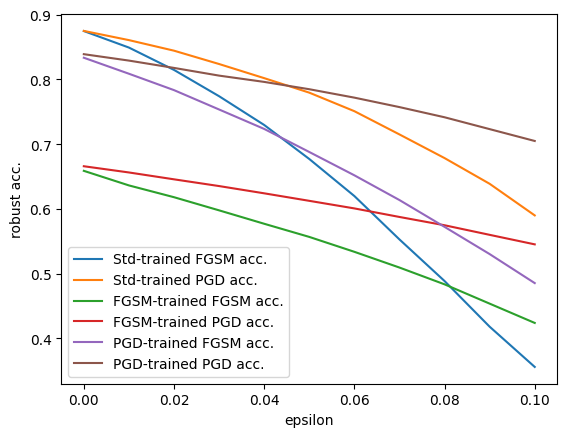

In [11]:
plt.plot(eps_list, std_model_fgsm, label='Std-trained FGSM acc.')
plt.plot(eps_list, std_model_pgd, label='Std-trained PGD acc.')

plt.plot(eps_list, fgsm_model_fgsm, label='FGSM-trained FGSM acc.')
plt.plot(eps_list, fgsm_model_pgd, label='FGSM-trained PGD acc.')

plt.plot(eps_list, pgd_model_fgsm, label='PGD-trained FGSM acc.')
plt.plot(eps_list, pgd_model_pgd, label='PGD-trained PGD acc.')

plt.xlabel('epsilon')
plt.ylabel('robust acc.')
plt.legend()
plt.show()

### *(d) Analysis of results (1.5 points)*

Describe and analyze the observations from the graph that you plotted in the previous question **(c)**.

**Overall Tendency**

1. **Observation:** Across all model types, robust accuracy consistently decreases as epsilon increases from 0 to 0.1.
   
- Analysis: It is consistent with our knowledge that, the bigger the perturbation is, the harder for models to maintain accurate predictions.

**Diffrent Robust Training Method**

1. **Blue line and Orange line Observation:** The robust accuracy of the standard training model drop sharply when epsilon is bigger than 0.02.
   
- Analysis: The standard model has little robustness, and it will be easily attacked.


2. **Green line and Red line Observation:**
FGSM-trained model has lower standard performance compared to the Standard and PGD-trained models. It is robust when facing attack with small epsilon (accuracy slowly decrease), but has a relatively low robust accuracy when the epsilon is big (bigger than 0.08).
    
- Analysis: The poor initial performance may be due to insufficient training (e.g., only 20 epochs). With extended training (e.g., 40 epochs), the loss converges more effectively, leading to improved standard and robust accuracy. However, the robustness of FGSM-trained models does not generalize well to stronger attacks or larger perturbations, suggesting limited scalability of this method.

3. **Purple line and Brown line Observation:** PGD-trained model is the most robust when facing PGD attack (Brown line); and it is also robust when facing FGSM attack (Purple line), although the robust accuracy declines sightly faster under FGSM attack.
   
- Analysis: PGD-trained model learns stable features through pgd_attacked_dataset, thus yielding the strongest robustness among three models. And this method is effective at teaching the model to generalize against different perturbation patterns compared to FGSM-trained method.





---



---

